# Paper Replication : Attentive Neural Process - 1D GP Hard Data

Last Update : 22 June 2019

**Aim**: 
- Investigating variants of [Attentive Neural Process] (ANP)
- Showing how to use the library to build more complicated models
- Use a more complicated dataset where the hyperparameters of the kernel vary

**Nota Bene:**
- Much of the work below does not follow any paper
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].

[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

As in the paper I use a dataset sampled from a squared-exponential kernel and small likelihood noise. The length_scale is sampled uniformly in `[.1,.6]` and the noise standard deviation in `[.1, 1]`.

In [4]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples
from utils.datasets import GPDataset

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression

# like described in paper
dataset = GPDataset(kernel=(WhiteKernel(noise_level_bounds=(.1, 1.)) +
                             RBF(length_scale_bounds=(.1, .6))),
                     min_max=(-2, 2),
                     n_samples=160000, # they use 1M iter of batch size 16, we split that in 100 epochs
                     n_points=100,
                     n_diff_kernel_hyp=1000) # they actually use a different for every batch (i.e. 10k) but would be slow and not much diff 

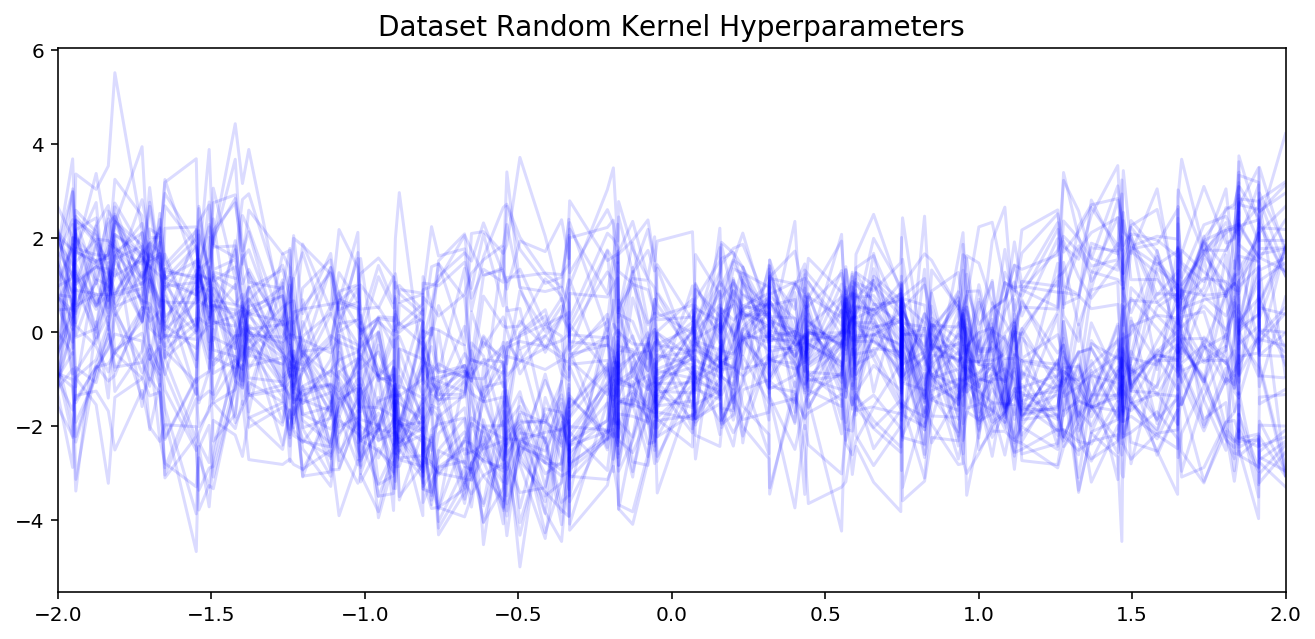

In [5]:
plot_dataset_samples(dataset, title="Dataset Random Kernel Hyperparameters")

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for all parameters. 

The only difference with the paper is that I also use the XEncoder they use for target embedding, for embedding the context. This does not increase the number of parameters but makes more sense (hopefully learning quicker).

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [8]:
from torch.distributions import Normal
from neuralproc import NeuralProcessLoss, AttentiveNeuralProcess, merge_flat_input
from neuralproc.utils.helpers import change_param
from neuralproc.utils.torchextend import MLP
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs

get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=3, max_n_indcs=50),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0, max_n_indcs=50),
                                 is_add_cntxts_to_trgts=True)  # add all context points to tagrtes

neural_proc = AttentiveNeuralProcess(X_DIM, Y_DIM, 
                 get_cntxt_trgt=get_cntxt_trgt,
                  aggregator=torch.mean,
                  LatentEncoder=change_param(MLP, n_hidden_layers=2),
                  XEncoder=change_param(MLP, n_hidden_layers=1),  # share X encoding (not done in the paper)
                  XYEncoder=merge_flat_input(change_param(MLP, n_hidden_layers=5),
                                             is_sum_merge=True),  # sum the encoded X and Y
                  Decoder=merge_flat_input(change_param(MLP, n_hidden_layers=4),
                                           is_sum_merge=True),  # sum the encoded X and Y
                  r_dim=128,
                  PredictiveDistribution=Normal,  # Gaussian predictive distribution
                  encoded_path="both",
                  attention = "multihead")  

/master/neuralproc/utils/torchextend.py:53: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/neuralproc/utils/torchextend.py:53: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [9]:
from utils.helpers import count_parameters
print("N Param:", count_parameters(neural_proc))

N Param: 312642


## Training

In [10]:
IS_RETRAIN = False

In [11]:
from torch.optim import Adam
from skorch import NeuralNet
from skorch.callbacks import ProgressBar, Checkpoint
from utils.helpers import get_only_first_item

chckpt = Checkpoint(dirname="results/notebooks/neural_process/paper_anp",
                    monitor='train_loss_best')  # train would be same as validation as always resamples

model = NeuralNet(neural_proc, NeuralProcessLoss,
                  iterator_train__shuffle=True,  # shuffle iterator
                  train_split=None,  # don't use cross validation dev set
                  warm_start=True,  # continue training if stop and restart
                  device="cuda" if torch.cuda.is_available() else "cpu",
                  optimizer=Adam,
                  max_epochs=100,
                  batch_size=16,  # very slow because of that
                  lr=5e-5,  
                  callbacks=[ProgressBar(), chckpt])

if IS_RETRAIN:
    # give both X and y to `forward`
    model.fit({'X': get_only_first_item(dataset), "y": dataset.targets})

# load in all case => even when training loads the best checkpoint
model.initialize()
model.load_params(checkpoint=chckpt)

# Trained Prior

In [12]:
EXTRAP_DISTANCE = 1.5  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.5079213070869444


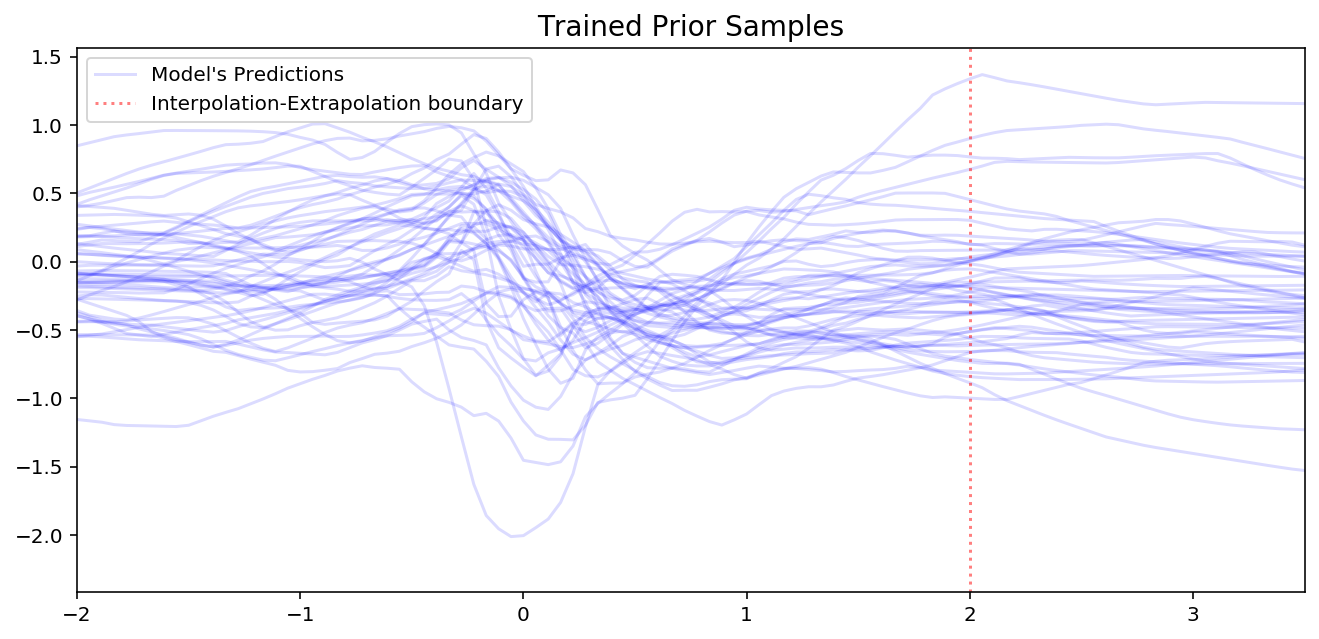

In [13]:
plot_prior_samples(neural_proc, 
                   title="Trained Prior Samples", 
                   test_min_max=EXTRAPOLATION_RANGE, 
                   train_min_max=INTERPOLATION_RANGE)

# Posterior

Let's see how well it does on samples from random kernel hperparameters.

std: 1.1958431005477905
std: 1.2390663623809814
std: 1.1736384630203247
std: 1.0038496255874634
std: 0.9020619988441467
std: 0.864622175693512
std: 0.8077220320701599
std: 0.8647092580795288


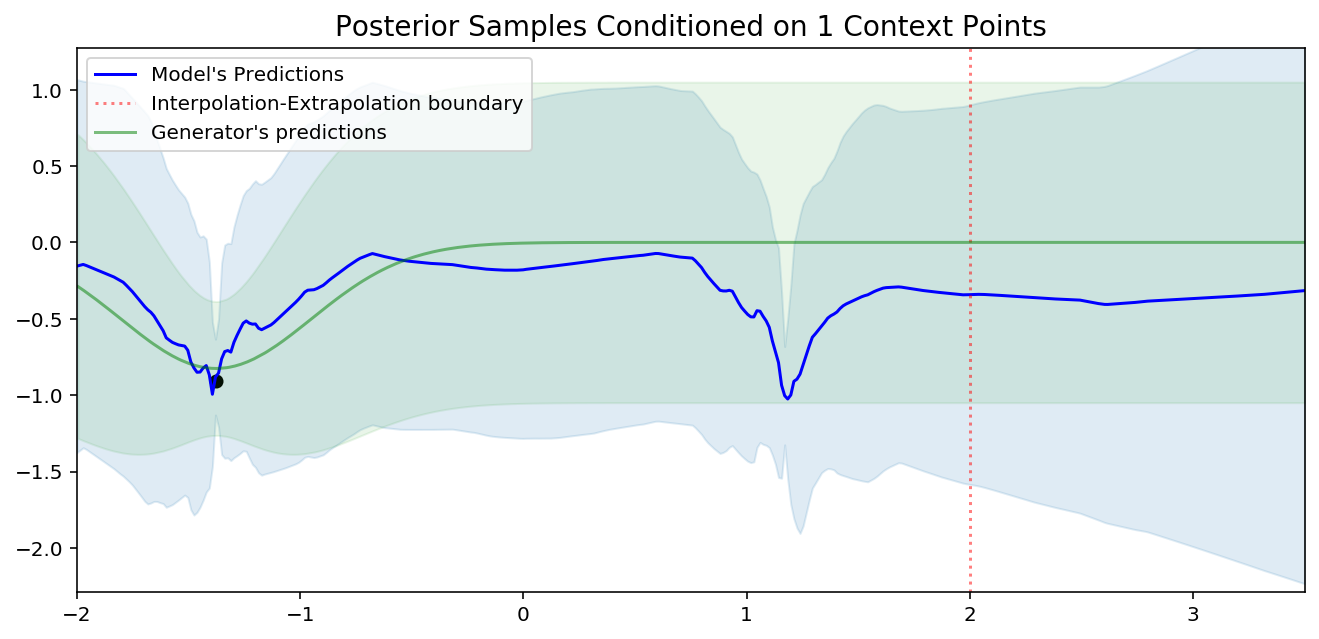

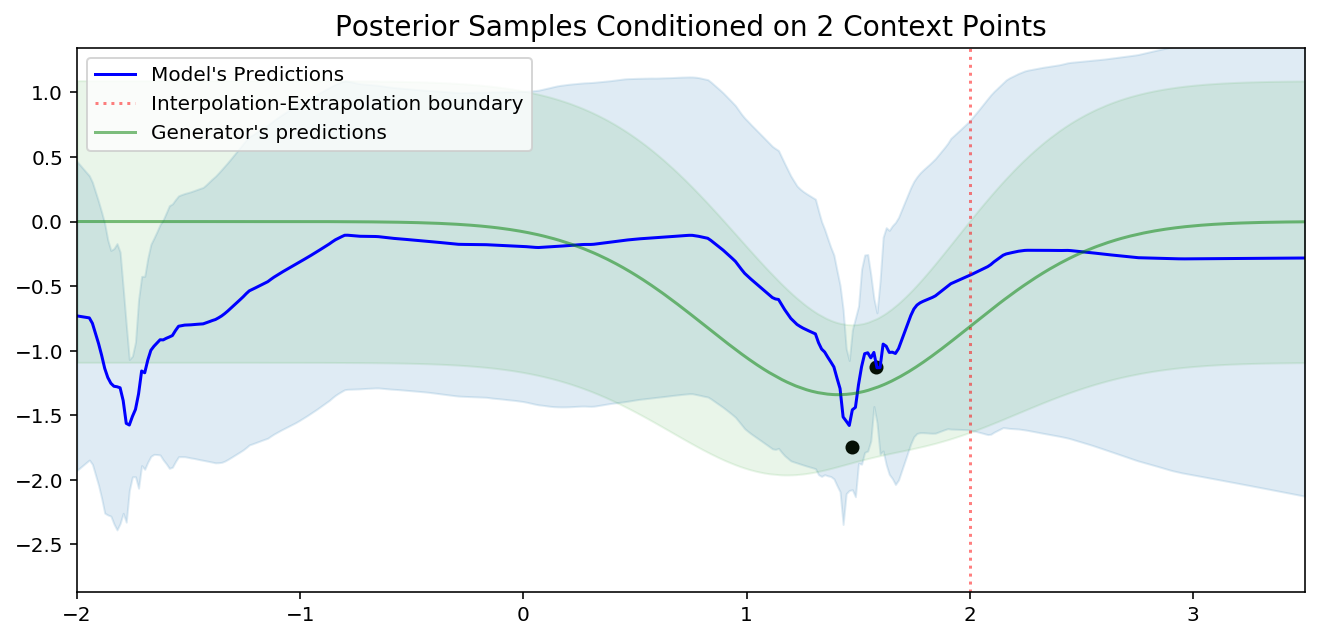

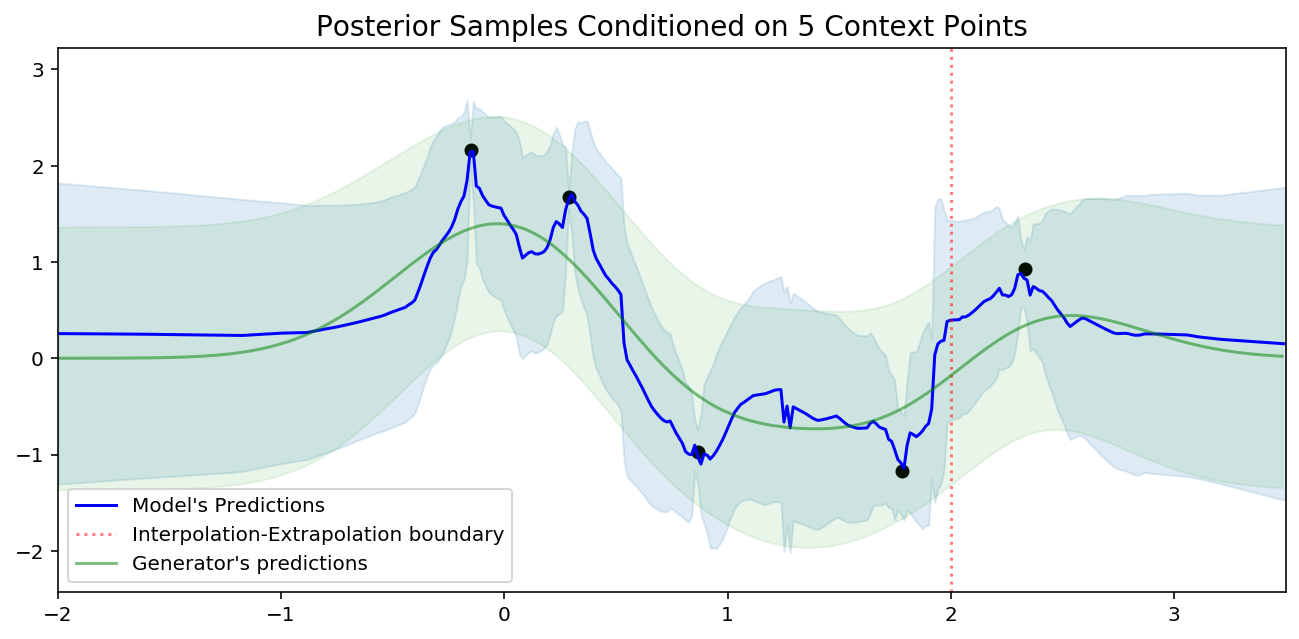

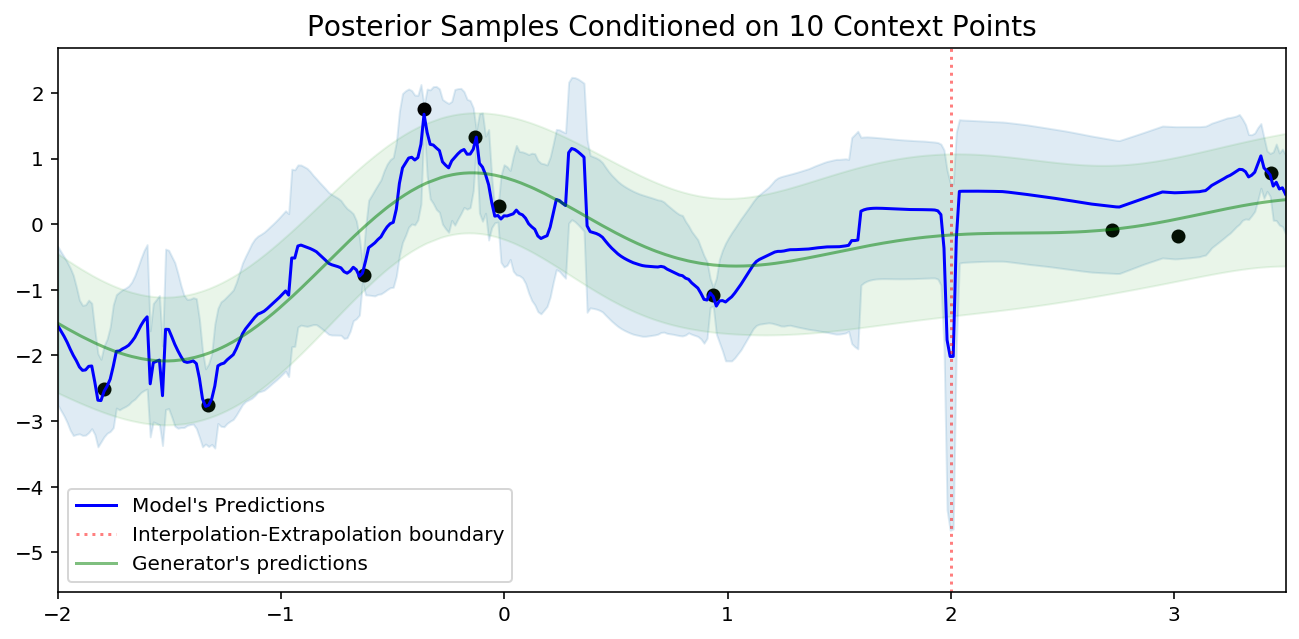

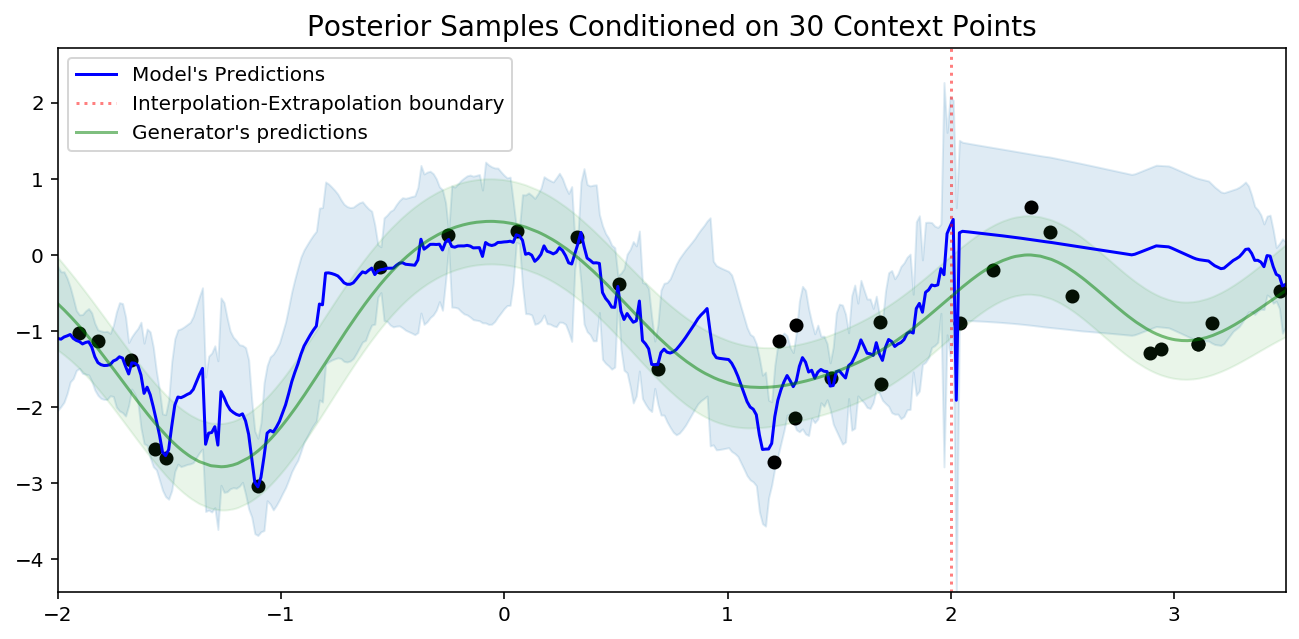

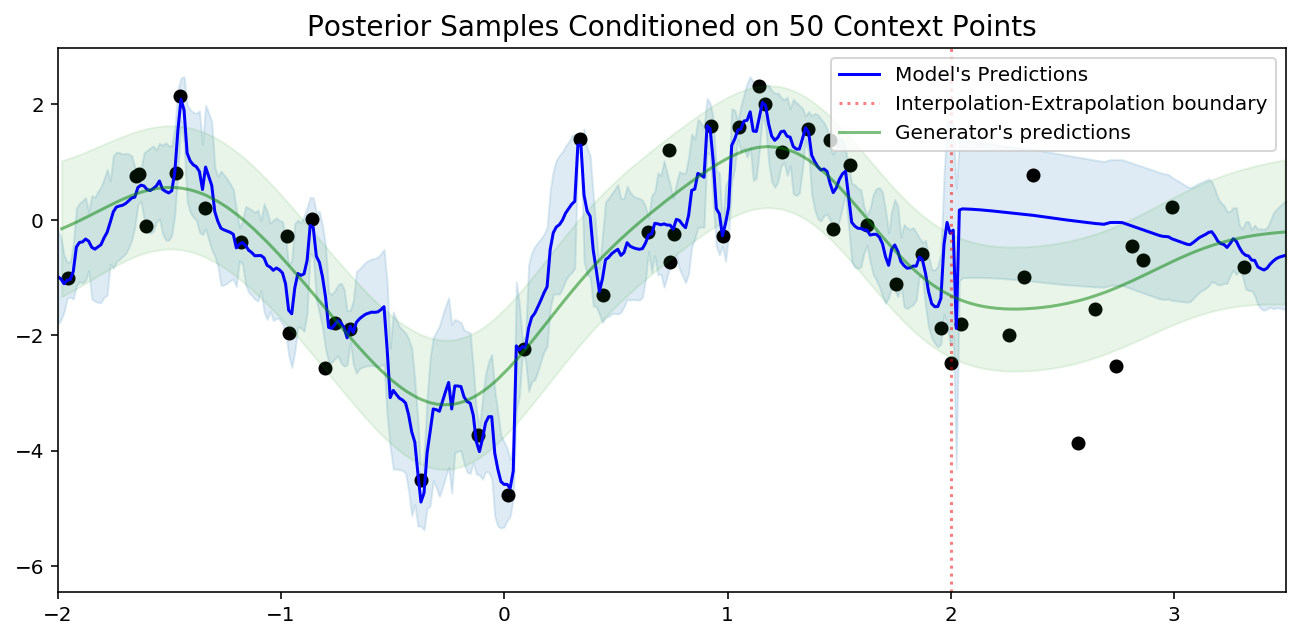

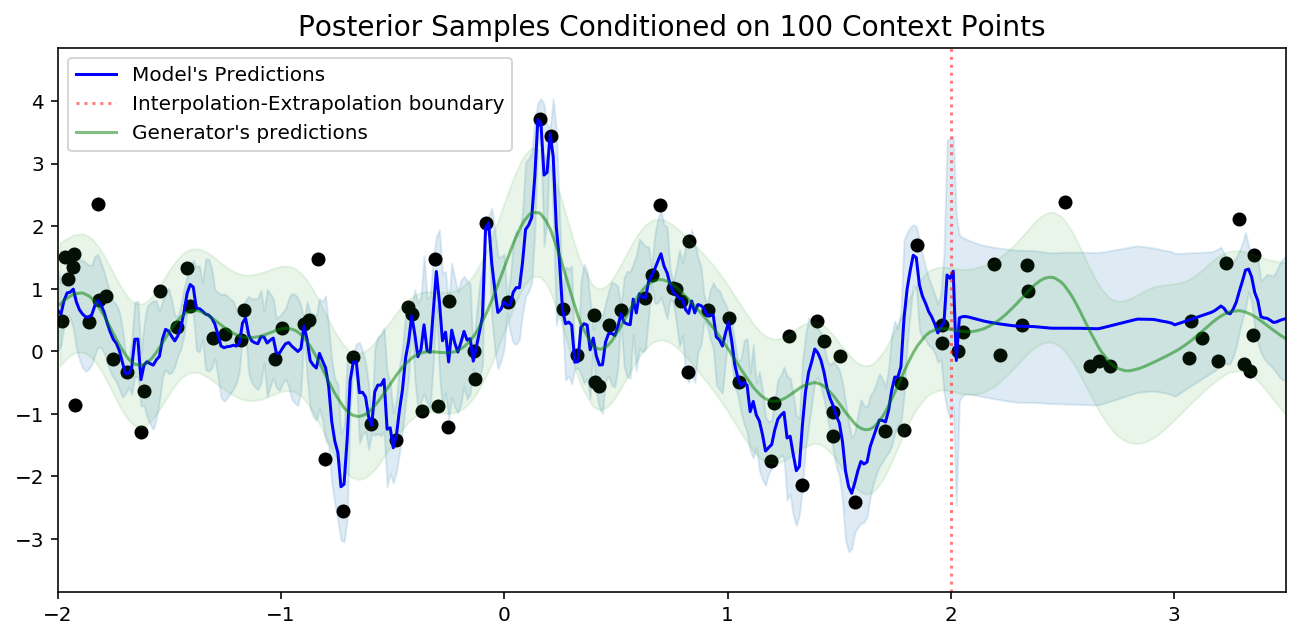

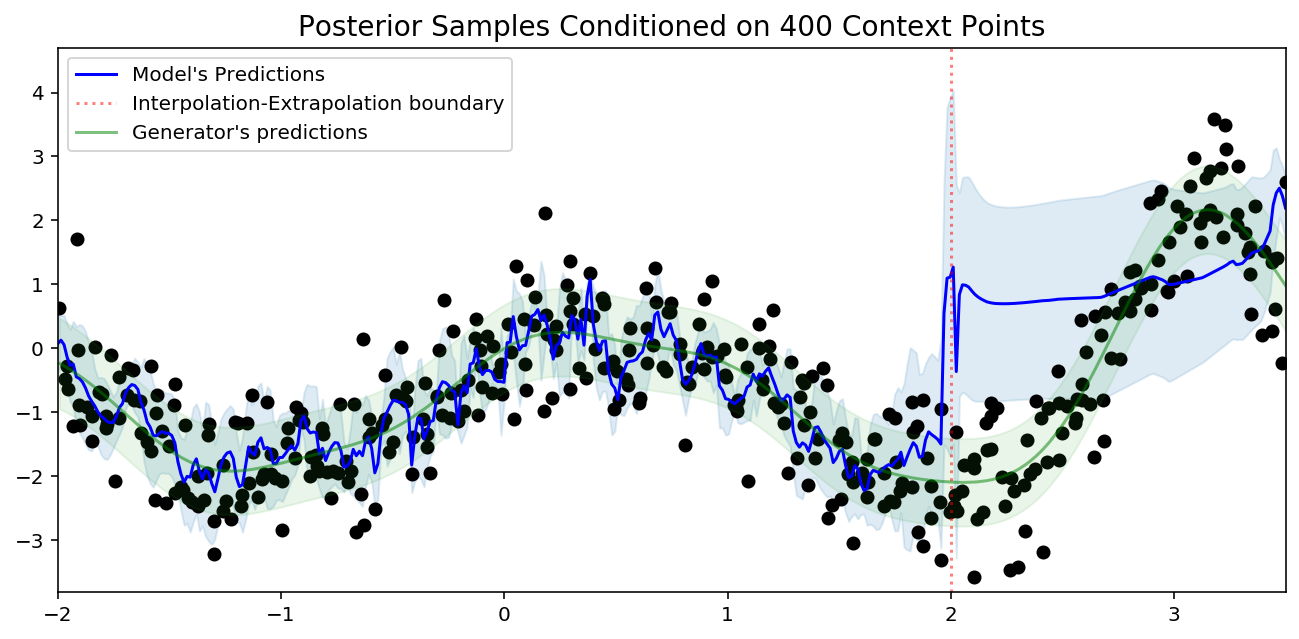

In [14]:
for n_cntxt in [1,2,5,10,30,50,100,400]:
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=n_cntxt, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=400,
                           n_samples=1,
                           is_true_func=False,
                           title="Posterior Samples Conditioned on {} Context Points".format(n_cntxt))

Let's now see how well it does on samples with the minimum length scale and noise

In [15]:
dataset.n_diff_kernel_hyp = 1 # deactivate sampling
dataset.generator.kernel.set_params(k1__noise_level=.1) 
dataset.generator.kernel.set_params(k2__length_scale=.1)

WhiteKernel(noise_level=0.1) + RBF(length_scale=0.1)

std: 1.5170066356658936
std: 1.245617389678955
std: 1.178219199180603
std: 1.0637341737747192
std: 0.8875312805175781
std: 0.7703443765640259
std: 0.7313665747642517
std: 0.6940709948539734


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([10.6031862 , -0.02256732]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


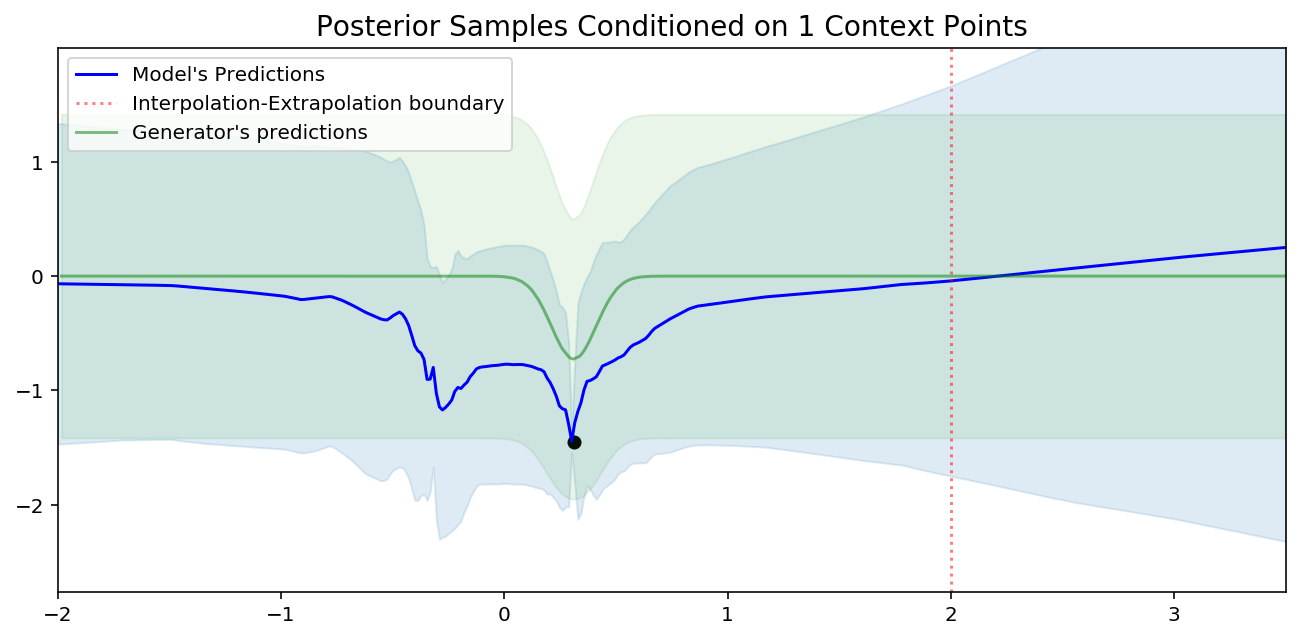

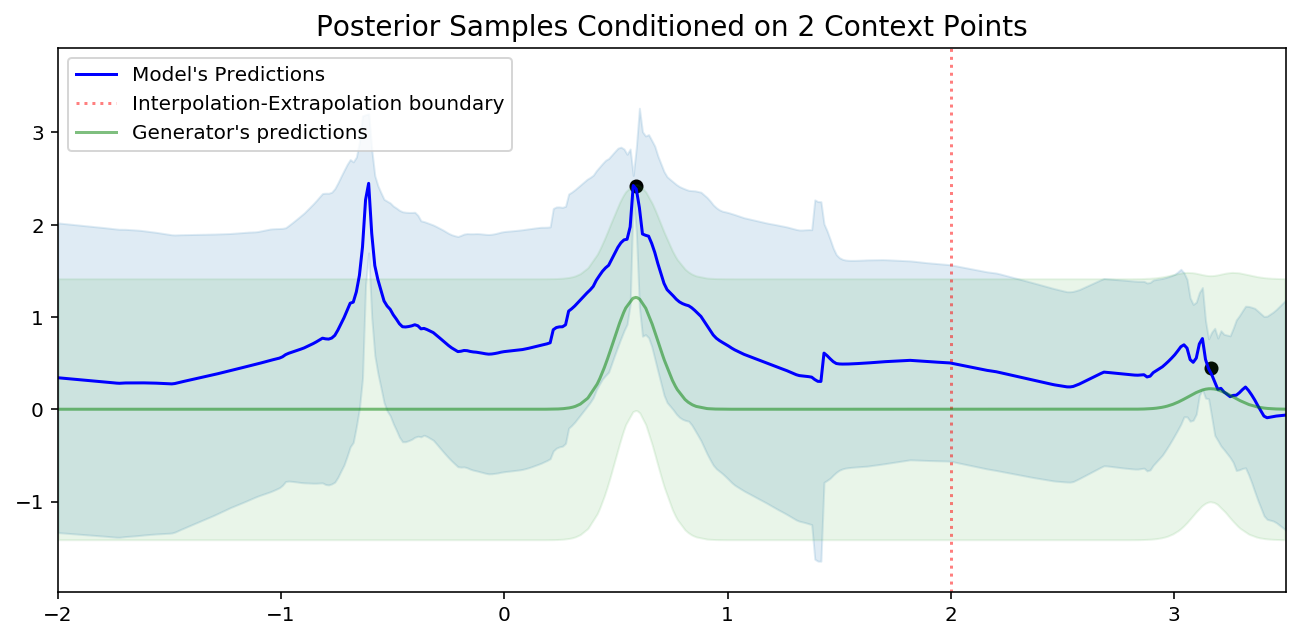

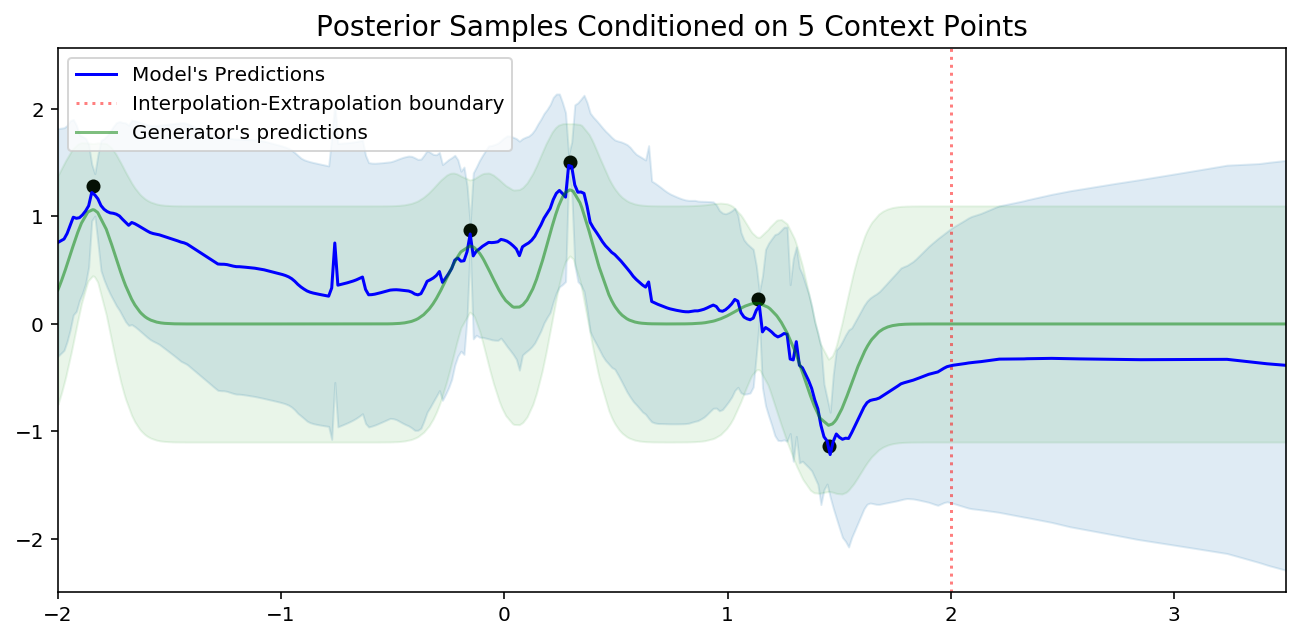

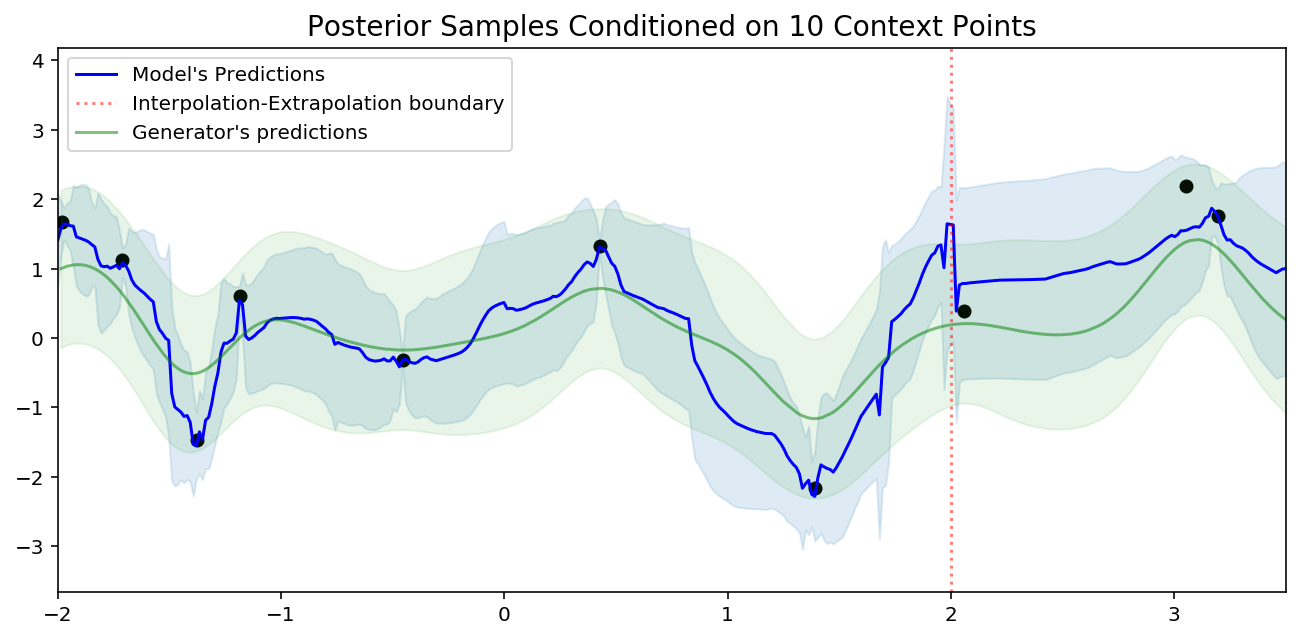

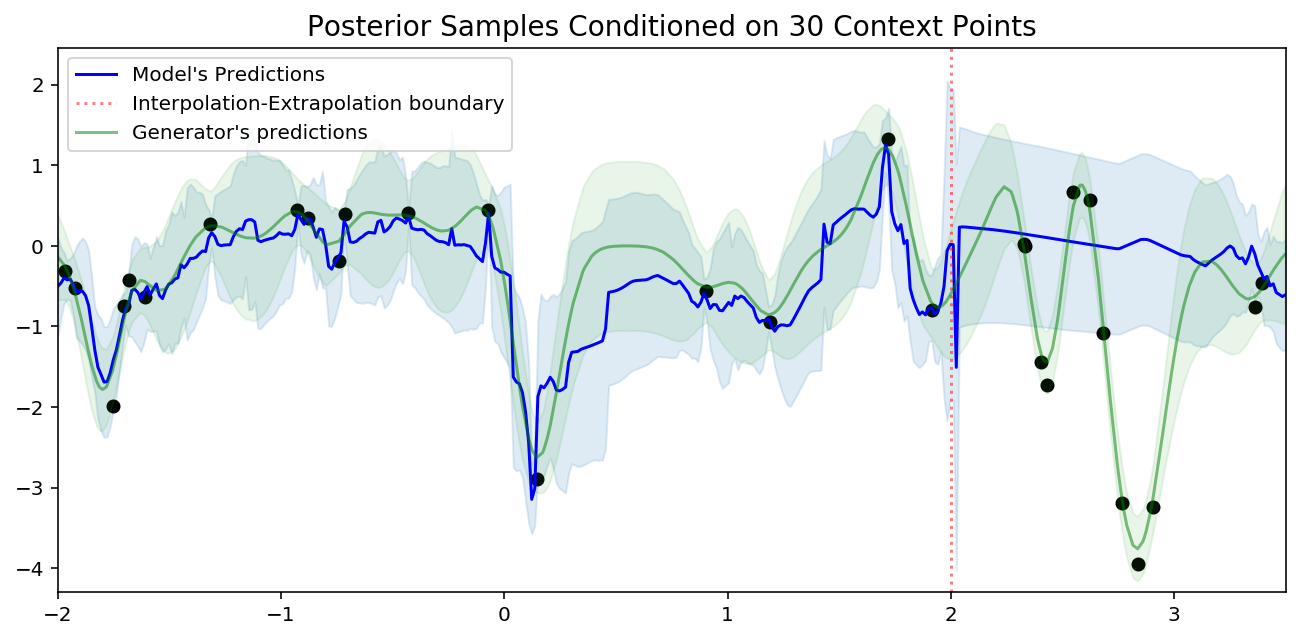

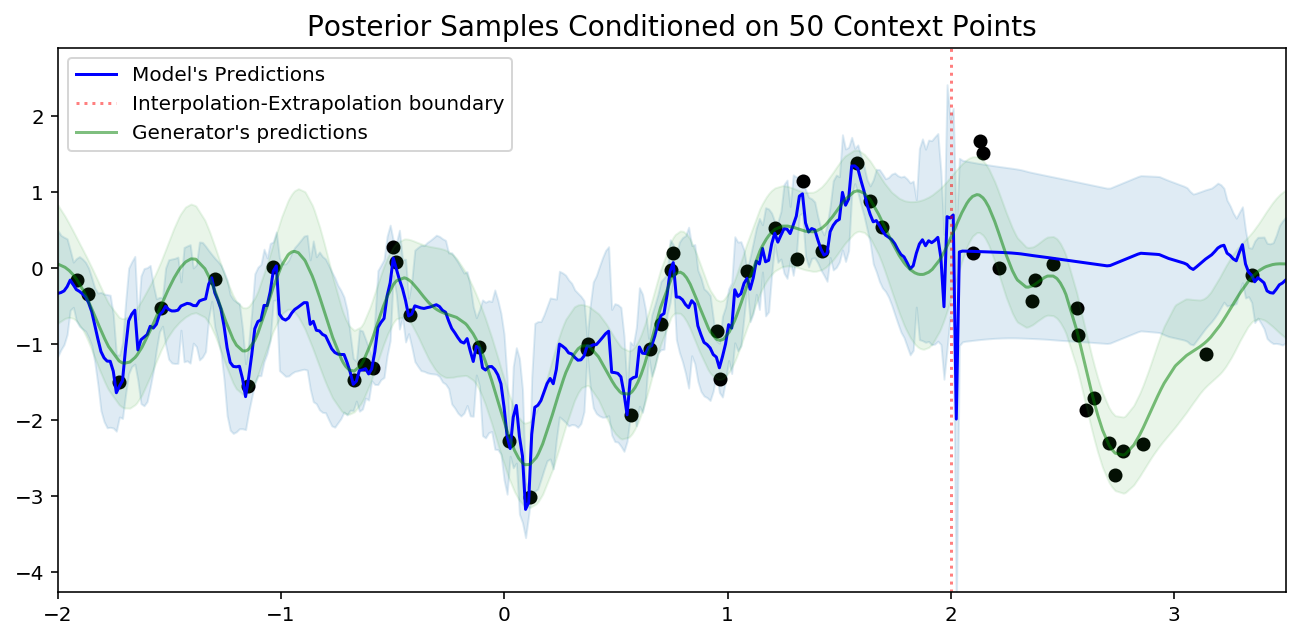

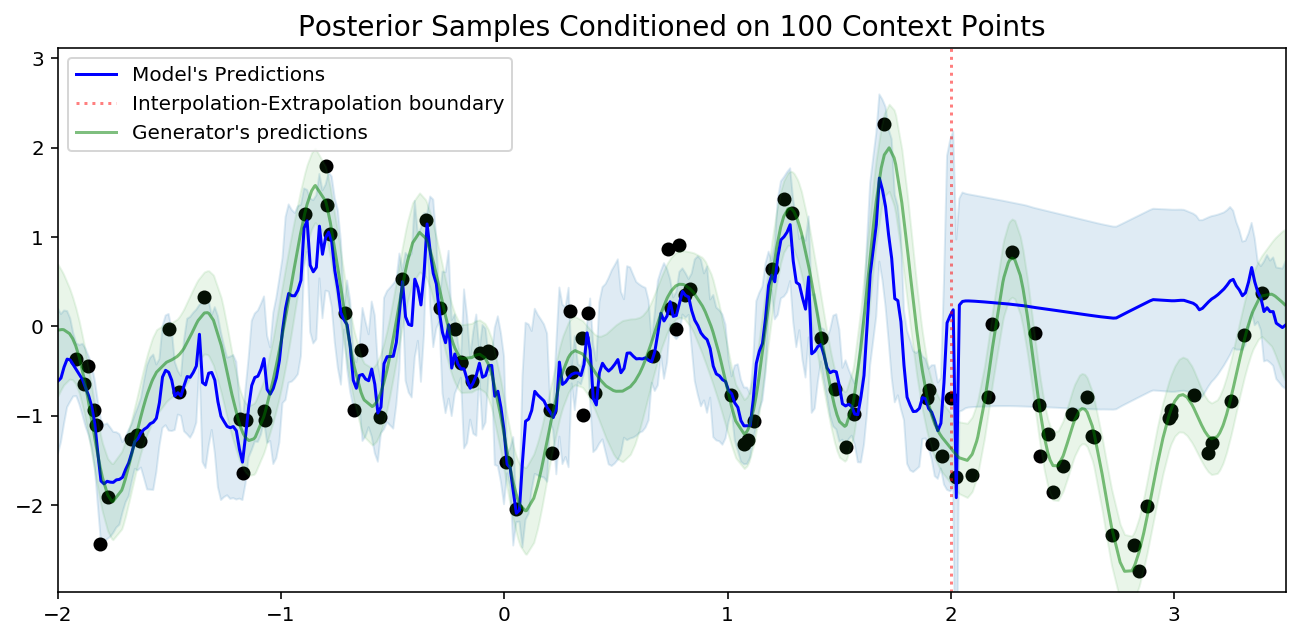

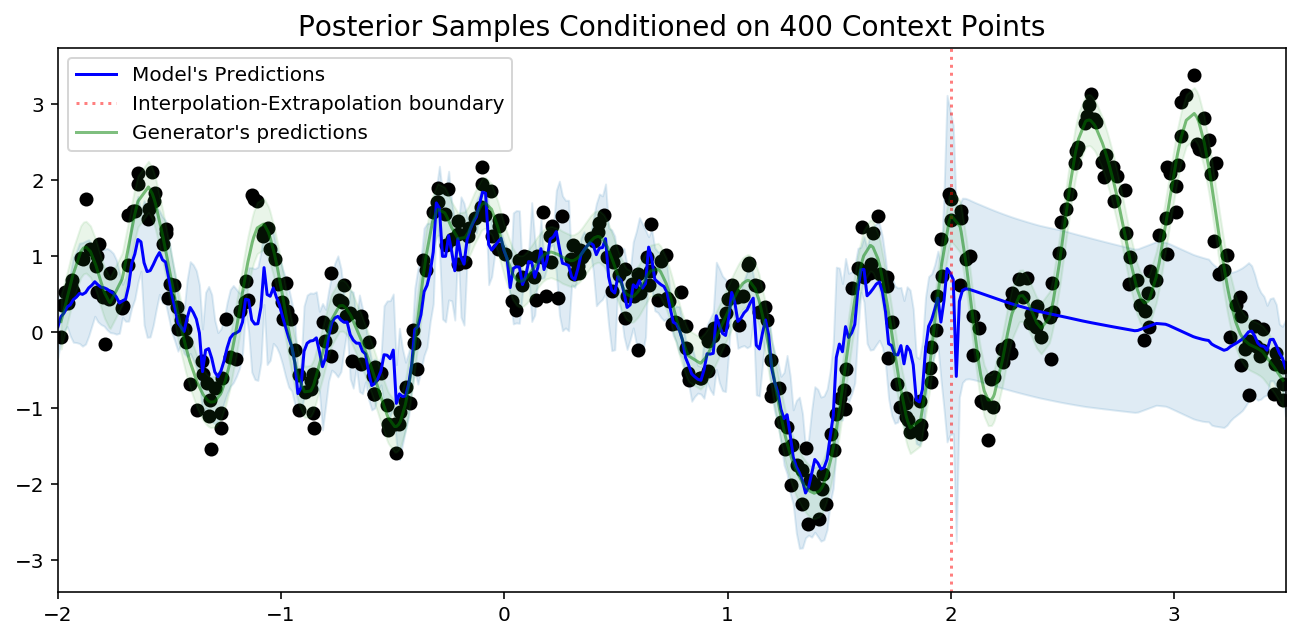

In [16]:
for n_cntxt in [1,2,5,10,30,50,100,400]:
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=n_cntxt, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=400,
                           n_samples=1,
                           is_true_func=False,
                           title="Posterior Samples Conditioned on {} Context Points".format(n_cntxt))